# PortfolioOptimiser.jl

This is a demo for getting started with `PortfolioOptimiser.jl`.

In [1]:
using PortfolioOptimiser
using CSV, DataFrames, Plots, CovarianceEstimation, LinearAlgebra, Statistics, MarketData, JuMP, IJulia
gr(fmt=:png);

## Loading data

All our functions take AbstractArray or Tuple arguments, not DataFrame or TimeArray data. We do this to minimise dependencies and to keep the code as generic and performant as possible.

We have some data in the `assets` folder but [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) can be used to download it, as we will show later.

In the first few sections, we'll load the data in the `assets` folder using [`CSV.jl`](https://github.com/JuliaData/CSV.jl) and [`DataFrames.jl`](https://github.com/JuliaData/DataFrames.jl). We'll later show the use of [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) and [`TimeSeries.jl`](https://github.com/JuliaStats/TimeSeries.jl) for downloading price data.

In [2]:
hist_prices = CSV.read("./assets/stock_prices.csv", DataFrame)
dropmissing!(hist_prices)

896×21 DataFrame
 Row │ date        GOOG      AAPL      FB       BABA     AMZN     GE       AMD ⋯
     │ Date        Float64   Float64   Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2014-09-19   592.82    94.7721    77.91    93.89   331.32  23.421       ⋯
   2 │ 2014-09-22   584.158   94.866     76.8     89.89   324.5   23.2339
   3 │ 2014-09-23   577.952   96.3492    78.29    87.17   323.63  23.1805
   4 │ 2014-09-24   584.775   95.5137    78.54    90.57   328.21  23.1003
   5 │ 2014-09-25   571.915   91.8715    77.22    88.92   321.93  22.7618      ⋯
   6 │ 2014-09-26   573.944   94.575     78.79    90.46   323.21  22.833
   7 │ 2014-09-29   573.208   93.9743    79.0     88.75   321.82  22.646
   8 │ 2014-09-30   574.203   94.575     79.04    88.85   322.44  22.8241
  ⋮  │     ⋮          ⋮         ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 890 │ 2018-04-03  1013.41   168.39     156.11   174.67  1392.05  13.13        ⋯
 891 │ 2018-04-04  1025.14   171.61     155.1    172.07  1410.57  13.28
 892 │ 2018-04-05  1027.81   172.8      159.34   172.57  1451.75  13.43      1
 893 │ 2018-04-06  1007.04   168.38     157.2    167.52  1405.23  13.06
 894 │ 2018-04-09  1015.45   170.05     157.93   169.87  1406.08  12.83        ⋯
 895 │ 2018-04-10  1031.64   173.25     165.04   177.1   1436.22  13.05
 896 │ 2018-04-11  1019.97   172.44     166.32   175.36  1427.05  12.97
                                                 14 columns and 881 rows omitted

## Returns

`PortfolioOptimiser.jl` calculates a variety of returns and expected returns from the historical price data. Here we use daily prices, but we can use any price frequency. However, when using other price frequencies, you should adjust the `freq` parameters in the corresponding functions.

### Historical returns

For historical returns, we can calculate regular and log returns with the function `returns_from_prices`. 

Log returns are useful because they can be added instead of multiplied when compounding. The function defaults to regular returns.

In [3]:
returns = returns_from_prices(hist_prices[!, 2:end])
log_returns = returns_from_prices(hist_prices[!, 2:end], true)
exp.(log_returns) .- 1 ≈ returns

true

We can also recover relative prices from historical returns. Since DataFrames does not define `cumprod` we must use arrays.

In [4]:
rel_prices = prices_from_returns(Matrix(returns[!, :]))
rel_prices_log = prices_from_returns(Matrix(log_returns[!, :]), true)
rel_prices ≈ rel_prices_log

true

And we can reconstruct the original prices by multiplying the first entry of historical prices by the corresponding relative prices.

In [5]:
reconstructed_prices = (rel_prices' .* Vector(hist_prices[1, 2:end]))'
reconstructed_prices ≈ Matrix(hist_prices[!, 2:end])

true

### Expected returns

We have a few ways of calculating a variety of expected/mean returns:

- arithmetic mean
- exponentially weighted arithmetic mean
- capital asset pricing model (CAPM)
- exponentially weighted capital asset pricing model

The optional keyword arguments are further explained in the docs.

In theory, exponentially weighted returns are more predictive of future returns, as they assign higher weights to more recent values. 

The CAPM is a more stable return measure because it accounts for the return value, covariance to other assets, covariance to the market, and risk free rate. The exponential version simply uses exponential returns to calculate the mean market return.

When you don't provide a vector of market returns to the CAPM returns (which is the case here), they are calculated as the mean of the returns of the assets provided for each observation.

In [6]:
# Number of rows and columns for calculating the exponential weights.
num_rows = nrow(returns)
num_cols = ncol(returns)

# Split the returns 
past_returns = Matrix(returns[1:div(num_rows, 2), :])
future_returns = Matrix(returns[(div(num_rows, 2)+1):end, :])

# Arithmetic future returns.
mean_future_rets = ret_model(MRet(), future_returns)

# Various past mean returns.
mean_ret = ret_model(MRet(), past_returns)
e_mean_ret = ret_model(EMRet(), past_returns)#, span = num_rows / 2)
capm_ret = ret_model(CAPMRet(), past_returns)
e_capm_ret = ret_model(ECAPMRet(), past_returns)#, cspan = num_rows / 2, rspan = num_rows / 2)

DataFrame(future = mean_future_rets, mean = mean_ret, emean = e_mean_ret, capm = capm_ret, ecapm = e_capm_ret)

┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30
┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30


20×5 DataFrame
 Row │ future      mean         emean       capm       ecapm     
     │ Float64     Float64      Float64     Float64    Float64   
─────┼───────────────────────────────────────────────────────────
   1 │  0.251907    0.084095     0.0966601  0.0733891  0.11621
   2 │  0.42774    -0.0192506   -0.113424   0.0775557  0.128924
   3 │  0.235747    0.240336     0.303843   0.0816804  0.136766
   4 │  0.576821   -0.0989912    0.0321639  0.0865019  0.151806
   5 │  0.474416    0.543596     0.649783   0.0862735  0.143421
   6 │ -0.362388    0.125079     0.177431   0.0712196  0.119963
   7 │  0.44086     0.182588     2.23538    0.142432   0.30758
   8 │  0.12899    -0.00619495   0.114549   0.0519984  0.0776635
  ⋮  │     ⋮            ⋮           ⋮           ⋮          ⋮
  14 │ -0.0613527   0.00517498   0.188566   0.071053   0.115011
  15 │ -0.452307   -0.237187     0.366896   0.108906   0.210367
  16 │  0.648166   -0.0427683   -0.0123966  0.083751   0.132949
  17 │  0.433993    0.112071     0.0555051  0.0803037  0.137828
  18 │  0.050772    0.120351     0.175592   0.0586689  0.0917498
  19 │  0.433141    0.0280035    0.0381675  0.0883728  0.16259
  20 │  0.0448829   0.275368     0.146989   0.0732492  0.12166
                                                   5 rows omitted

Note how there are four warnings regarding the covariance matrix not being positive definite. These are from the CAPM returns, because they require a covariance matrix to the market. We can use more robust estimates of the covariance, such as those in [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl) by passing `CustomCov()` or `CustomSCov()` via the `cov_type` keyword argument. One of the advantages of Julia is that multiple dispatch makes it possible to extend `cov` from `StatsBase`. Which means we're not bound to any covariance estimator, `args` or `kwargs`. These can be passed on to the `CAPM()` and `ECAPM()` return models via the `custom_cov_estimator`, `custom_cov_args` and `custom_cov_kwargs` keyword arguments.

As a general rule, downside risk tends to be more stable, to prove this we use both the shrunken covariance and shrunken semicovariance.

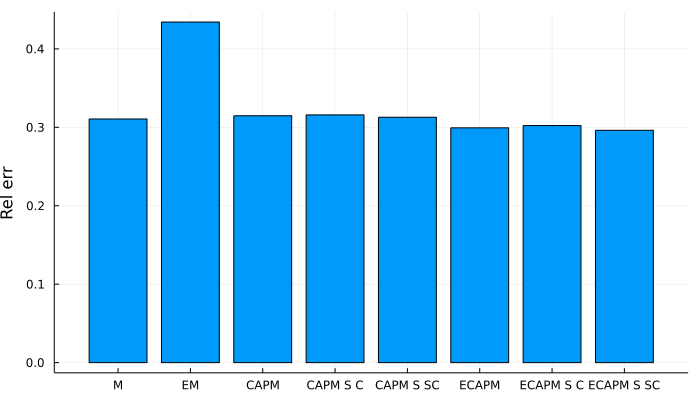

[0.31063526256932866, 0.43425887527522783, 0.31474257003293027, 0.31587044704120426, 0.31284742055462733, 0.29932550854796336, 0.30221366365012975, 0.2961737834777668]


In [7]:
# Covariance estimation parameters. We use Oracle Approximating.
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

# Different CAPM reutrns with shrunken covariances.
capm_ret_shrunken_cov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_cov = ret_model(
    ECAPMRet(),
    past_returns,
    # cspan=num_rows / 2,
    # rspan=num_rows / 2,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

capm_ret_shrunken_scov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_scov = ret_model(
    ECAPMRet(),
    past_returns,
    # cspan=num_rows / 2,
    # rspan=num_rows / 2,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

errors = Float64[]
push!(errors, sum(abs.(mean_future_rets - mean_ret)))
push!(errors, sum(abs.(mean_future_rets - e_mean_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_scov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_scov)))

errors /= length(mean_future_rets)

fig = plot(
    ["M", "EM", "CAPM", "CAPM S C", "CAPM S SC", "ECAPM", "ECAPM S C", "ECAPM S SC"],
    errors,
    ylabel="Rel err",
    legend=false,
    size=(700, 400),
    seriestype=:bar,
)

display(fig)

println(errors)

Returns are chaotic and unpredictable, so it's often better to optimise portfolios without considering them. In this case, the average absolute errors are all around 30 %. If we were to have a portfolio with a 10 % expected return, it could actually return between [-20, 40] %.

As a result, `min_risk!` portfolios tend to give more stable portfolios. If you really want to use returns, it's better to use some type of CAPM return with a shrunken covariance.

In the following cell, we plot all the return types we've calculated to see how they compare to each other.

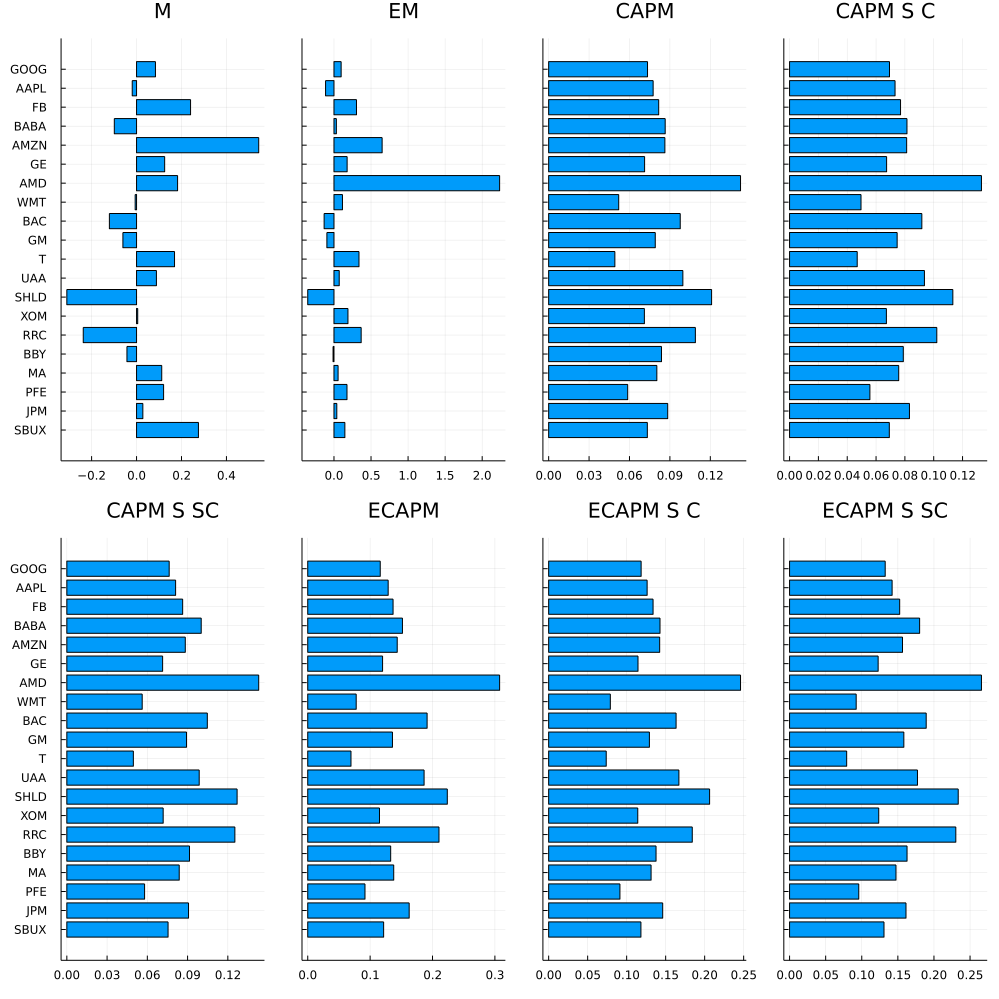

In [8]:
l = @layout [a b c d; e f g h]

fig1 = bar(
    mean_ret,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "M",
)

fig2 = bar(
    e_mean_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "EM",
)

fig3 = bar(
    capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM",
)

fig4 = bar(
    capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S C",
)

fig5 = bar(
    capm_ret_shrunken_scov,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S SC",
)

fig6 = bar(
    e_capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM",
)

fig7 = bar(
    e_capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S C",
)

fig8 = bar(
    e_capm_ret_shrunken_scov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S SC",
)

plot(fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, layout = l, size = (1000, 1000))

There's strong correspondence between exponential and non-exponentially weighted return types. CAPM returns are a little bit different as they account for an asset's relationship to the market via a covariance matrix, and the risk free rate. So although they seem quite different, they are a better, if more opaque measure.

## Risk models

We also have a few built-in risk models. However, as we mentioned in the previous section, using `CustomCov()` and `CustomSCov()` we can tap into more robust models, like those in [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl).

We provide a variety of covariance measures:

- sample covariance
- exponentially weighted sample covariance
- semicovariance
- exponentially weighted semicovariance
- custom covariance
- custom semicovariance

When using `CustomCov()` and `CustomSCov()`, `PortfolioOptimiser.cov` has the optional keyword arguments `estimator`, `args`, `kwargs`[^1] for the same purpose. The docs contain more information on this. We also have a wrapper function that contains all `PortoflioOptimiser.cov` functions, that function uses `custom_cov_estimator`, `custom_cov_args`, `custom_cov_kwargs`.

We can see how effective each covariance estimator is at estimating future asset variances and semivariances. The `span` keyword is the span parameter for calculating the exponential weights, the default value is:

```julia
Int(
        ceil(
            size(returns, 1) * log2(min(size(returns, 1), freq)) /
            log2(max(size(returns, 1), freq)),
        ),
    )
```

where `freq` is the frequency of the observations, in this case we're using daily returns, the default is the average number of daily returns per year, 252. This is a suitable value, as it captures recent trends as a function of how far back we're going. The further back in time we go, the larger the span value but the smaller it is in proportion to the length of time we're searching. Change the value of the spans that affects the answer.

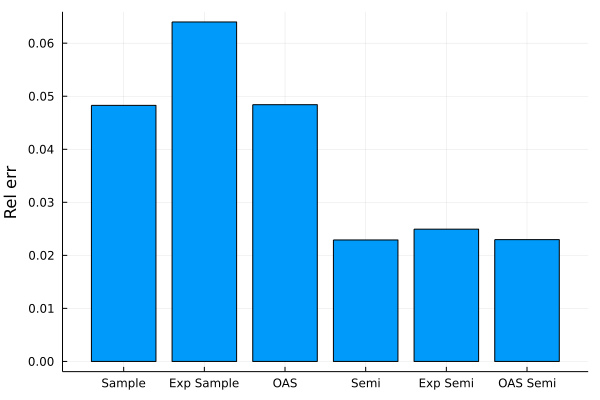

[0.04827333795084753, 0.0639965302819514, 0.04840679544002764, 0.022906141382702475, 0.02494122099202476, 0.022958747397658408]


In [9]:
future_cov = cov(Cov(), future_returns)
future_semi_cov = cov(SCov(), future_returns)

sample_cov = cov(Cov(), past_returns)
e_cov = cov(ECov(), past_returns)#, span=num_rows / 2)
semi_cov = cov(SCov(), past_returns)
e_semi_cov = cov(ESCov(), past_returns)#, span=num_rows / 2)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

oas_shrunken_cov = Matrix(cov(CustomCov(), past_returns, estimator=method))
oas_shrunken_cov_semi_cov = Matrix(cov(CustomSCov(), past_returns, estimator=method))

future_var = diag(future_cov)
future_semivar = diag(future_semi_cov)

errors = Float64[]
push!(errors, sum(abs.(future_var - diag(sample_cov))))
push!(errors, sum(abs.(future_var - diag(e_cov))))
push!(errors, sum(abs.(future_var - diag(oas_shrunken_cov))))
push!(errors, sum(abs.(future_semivar - diag(semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(e_semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(oas_shrunken_cov_semi_cov))))

errors /= length(future_var)

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel="Rel err",
    legend=false,
)

display(fig)

println(errors)

This is a toss up, as the non exponentially weighted estimators did a better job of estimating the future asset variances and semivariances than the corresponding exponentially weighted ones. The shrunken estimators were about as effective as their non-shrunken counterparts. Shrunken covariances should be the default choice, since they dampen the more extreme deviations from the mean. Thus they prevent the optimisers from overfitting the model to outliers.

This graph also lends more weight to the concept of using optimisations which account for downside risk, such as `EffMeanSemivar`, `EffCVaR` and `EffCDaR` optimisations. As well as using some type of semicovariance as the input covariance matrix for Black-Litterman and Hierarchical Risk Parity optimisations. The errors are also substantially smaller than those of mean returns, supporting the idea that minimising risk and ignoring mean returns is generally advised.

But what about the whole covariance?

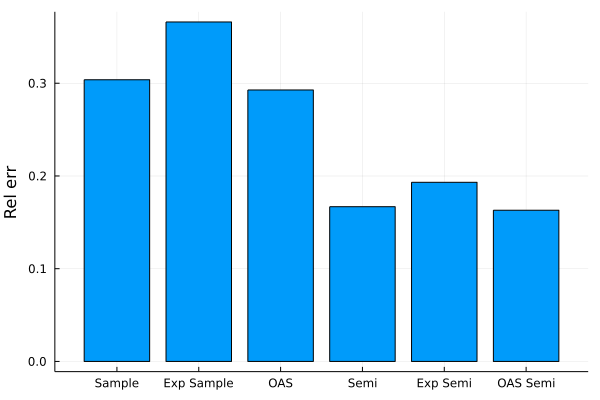

[0.30378672393598116, 0.36608115482490405, 0.29275023859924537, 0.16685498155701559, 0.19319424870772445, 0.1630895155655444]


In [10]:
errors = Float64[]
push!(errors, sum(abs.(future_cov - sample_cov)))
push!(errors, sum(abs.(future_cov - e_cov)))
push!(errors, sum(abs.(future_cov - oas_shrunken_cov)))
push!(errors, sum(abs.(future_semi_cov - semi_cov)))
push!(errors, sum(abs.(future_semi_cov - e_semi_cov)))
push!(errors, sum(abs.(future_semi_cov - oas_shrunken_cov_semi_cov)))

errors /= length(future_var)

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel = "Rel err",
    legend = false,
)

display(fig)

println(errors)

Again, this is a bit of a toss up between choosing exponentially weighted vs not, but the estimation error is again lower when using semicovariances.

If we plot the absolute percentage errors of each entry of the correlation matrices, we can see that the semicovariance is a more stable measure of the correlation between assets, as evidenced by how much darker the second plot is compared to the first.

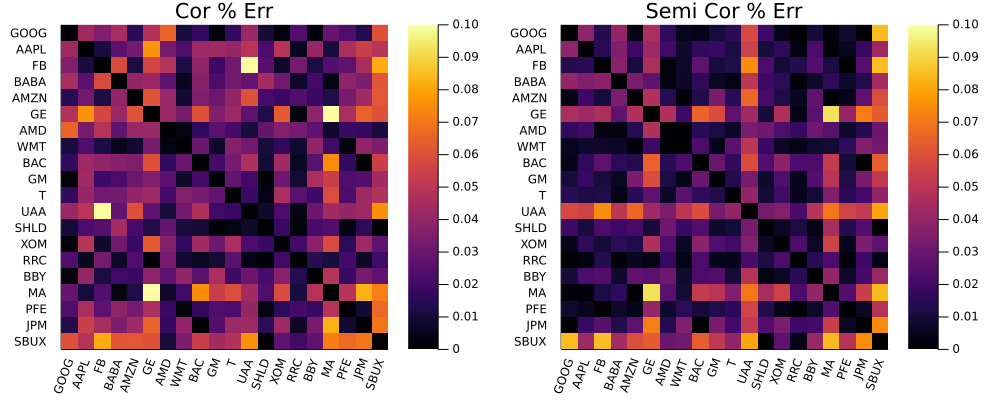

In [11]:
fig1 = heatmap(
    abs.(cov2cor(future_cov) - cov2cor(sample_cov)) / length(future_cov) * 100,
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-1),
    title = "Cor % Err"
)

fig2 = heatmap(
    abs.(cov2cor(future_semi_cov) - cov2cor(semi_cov)) / length(future_semi_cov) * 100,
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-1),
    title = "Semi Cor % Err"
)

IJulia.display(plot(fig1, fig2, size = (1000, 400), bottom_margin = 5Plots.mm))

## Downloading data

In this section we show how we can use [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) to download stock data, [`TimeSeries.jl`](https://github.com/JuliaStats/TimeSeries.jl) to select only the closing prices, and [`DataFrames.jl`](https://dataframes.juliadata.org/stable/) for plotting and other manipulation.

You can acquire lists of stocks from publicly available sources, such as the NASDAQ website, but we'll just provide a list of trendy stocks.

In [12]:
tickers = [
    "ACN",
    "AMZN",
    "COST",
    "DIS",
    "F",
    "GILD",
    "GME",
    "JPM",
    "KO",
    "LUV",
    "MA",
    "MSFT",
    "PFE",
    "TSLA",
    "UNH",
    "XOM",
];


We can download the data from Yahoo using [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl).

In [13]:
data = yahoo.(tickers)

16-element Vector{TimeArray{Float64, 2, Date, Matrix{Float64}}}:
 5266×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2001-07-19 to 2022-06-23
 6319×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1997-05-15 to 2022-06-23
 9064×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1986-07-09 to 2022-06-23
 12958×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1971-02-08 to 2022-06-23
 12625×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1972-06-01 to 2022-06-23
 7663×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1992-01-22 to 2022-06-23
 5126×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2002-02-13 to 2022-06-23
 10659×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1980-03-17 to 2022-06-23
 12958×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1971-02-08 to 2022-06-23
 10711×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1980-01-02 to 2022-06-23
 4048×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2006-05-25 to 2022-06-23
 9145×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1986-03-13 to 2022-

We'll use `merge` from [`TimeSeries.jl`](https://github.com/JuliaStats/TimeSeries.jl), rename the columns to match their ticker and put them in a dataframe.

In [14]:
# Merge only on the close data, see the docs for TimeSeries.
hist_prices = merge([data[i][:Close] for i in 1:length(data)]...)
# Convert to a DataFrame.
hist_prices = DataFrames.rename(DataFrame(hist_prices), ["timestamp"; tickers])

3018×17 DataFrame
  Row │ timestamp   ACN      AMZN      COST     DIS      F        GILD     GME ⋯
      │ Date        Float64  Float64   Float64  Float64  Float64  Float64  Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 2010-06-29    38.65    5.4305   55.63     32.3      9.88   17.485    1 ⋯
    2 │ 2010-06-30    38.65    5.463    54.83     31.5     10.08   17.14     1
    3 │ 2010-07-01    38.28    5.548    54.9      31.49    10.57   17.07     1
    4 │ 2010-07-02    37.94    5.457    54.23     31.38    10.28   17.435    1
    5 │ 2010-07-06    38.41    5.503    54.0      31.72    10.16   17.385    1 ⋯
    6 │ 2010-07-07    39.26    5.6715   54.29     33.14    10.59   17.47     1
    7 │ 2010-07-08    39.34    5.811    55.71     33.34    10.62   17.41     1
    8 │ 2010-07-09    39.42    5.863    56.19     33.75    10.85   17.37     1
  ⋮   │     ⋮          ⋮        ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 3012 │ 2022-06-14   275.12  102.31    454.8      94.22    12.2    57.79    12 ⋯
 3013 │ 2022-06-15   281.19  107.67    458.79     95.88    12.27   58.39    12
 3014 │ 2022-06-16   270.9   103.66    451.76     94.28    11.25   57.72    12
 3015 │ 2022-06-17   275.38  106.22    446.69     94.34    11.23   58.53    13
 3016 │ 2022-06-21   282.73  108.68    463.11     93.29    11.46   60.51    14 ⋯
 3017 │ 2022-06-22   286.4   108.95    459.96     93.5     11.48   61.51    13
 3018 │ 2022-06-23   284.27  111.14    472.375    93.3     11.36   62.17    13
                                                10 columns and 3003 rows omitted

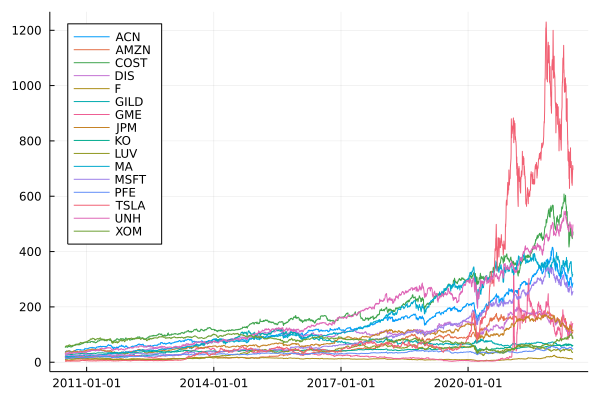

In [15]:
# Plot ticker closing prices.
fig = plot()
for ticker in tickers
    plot!(fig, hist_prices[!, 1], hist_prices[!, ticker], label=ticker)
end
plot(fig, legend=:topleft)

As previously stated, it's best to use a more stable measure of covariance other than the sample covariance matrix. The sample covariance can be subject to noise, particularly if the number of variables is greater than the number of observations. Furthermore, it can be sensitive to extreme outlier observations. We can avoid these by using a more sophisticated estimation of the covariance matrix.

We've been using [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl) for this tutorial, and I would recommend you use similarly robust estimators for your needs.

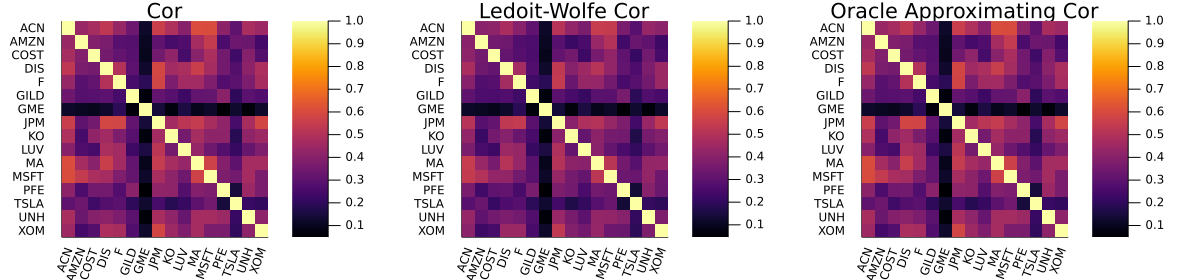

In [16]:
l = @layout [a b c]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

S = cov(Cov(), Matrix(returns), freq = 252)

fig1 = heatmap(
    cov2cor(S),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    title = "Cor"
)

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator=method)

fig2 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Ledoit-Wolfe Cor"
)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator=method)

fig3 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Oracle Approximating Cor"
)

IJulia.display(plot(fig1, fig2, fig3, size=(1200, 280), bottom_margin = 5Plots.mm, layout = l))

The `cov` functions defined in `PortfolioOptimiser.jl` also provide a way to use the semicovariance via the `CustomSCov()` struct. As shown in the following cell.

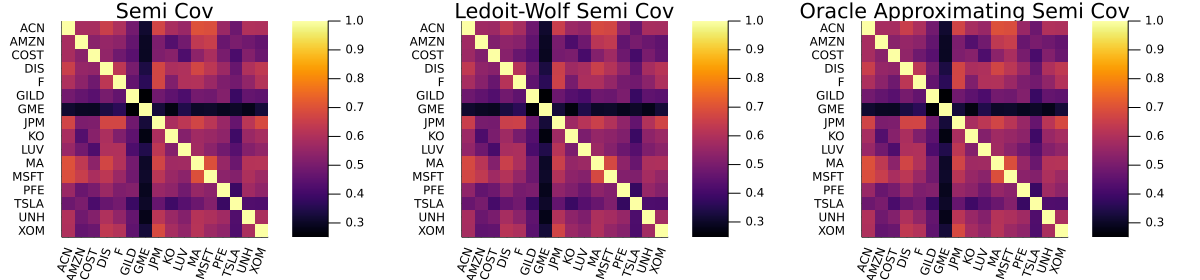

In [17]:
l = @layout [a b c]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

S = cov(SCov(), Matrix(returns), freq = 252)

fig1 = heatmap(
    cov2cor(S),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    title = "Semi Cov"
)

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)

S = cov(CustomSCov(), Matrix(returns), estimator=method)

fig2 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Ledoit-Wolf Semi Cov"
)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomSCov(), Matrix(returns), estimator=method)

fig3 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Oracle Approximating Semi Cov"
)

IJulia.display(plot(fig1, fig2, fig3, size=(1200, 280), bottom_margin = 5Plots.mm, layout = l))

# Efficient Frontier Optimisation

As previously stated, providing mean returns is not the best idea given how volatile they can be. Returns are optional on risk minimising portfolios `min_risk!`.

Every optimiser subtyped from `AbstractEfficient` has the following optimisation functions:

- `min_risk!`: minimises the risk measure.
- `max_sharpe!`: maximises `(return - rf)/risk`, where `rf` is the risk free rate. However, it's worth noting this uses a variable transformation to turn the non-convex optimisation problem into a convex one. If you want to use extra objective terms, you should use `custom_nloptimiser!` instead. More on that later.
- `max_utility!`: difference between the `return - l * risk`, where `l` is the risk aversion parameter divided by 2.
- `efficient_return!`: maximises the return with the constraint that the risk must be less than or equal to a specified value.
- `efficient_risk!`: minimises the risk with the constraint that the return must be equal to or greater than a specified value.

Crucially, all concrete `EfficientFrontier` contain a different set of fields given they all require different data. However they all contain a `model` field which stores a `JuMP` model with each optimisation's required `JuMP` variables and constraints. However all models contain a term for the return, `model[:ret]` (if `mean_ret` was provided), and risk, `model[:risk]`, measures. Currently, the only supported portfolio return is the arithmetic return, but this may be expanded in the future to account for other return types such as kelly objectives. The risk measure is dependent on the concrete type of the optimiser. Having a common naming scheme for the return and risk expressions lets users easily use them in their code, for example to build constraints.

As we are demonstrating all optimisation functions, we will provide mean returns. However, we'll use exponentially weighted CAPM returns, with a shrunken covariance. All our covariances (full and semi) will be Oracle Approximating shrunken covariances. This should give us relatively robust measures of returns and risk, reducing the chance to overfit noise.

See what happens when you change the value of `cspan` and `rspan` when calculating `ECAPMRet()` returns, which correspond to the span of the exponential weights applied to the covariance and returns respectively. What happens if you change the value of `span` when calculating `EMRet()`? Try a range of values.

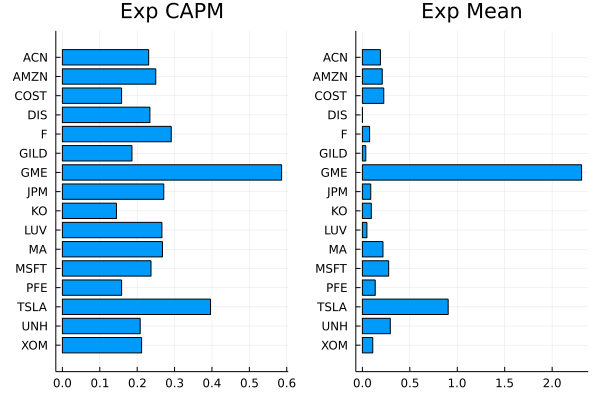

In [18]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator = method)

mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    # cspan = num_rows,
    # rspan = num_rows,
    cov_type = CustomCov(),
    custom_cov_estimator = method,
)

fig1 = bar(
    mean_ret,
    yticks = (1:num_cols, tickers),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "Exp CAPM",
)

fig2 = bar(
    ret_model(
        EMRet(),
        Matrix(returns),
        # span=num_rows,
    ),
    yticks=(1:num_cols, tickers),
    orientation=:h,
    yflip=true,
    legend=false,
    title="Exp Mean",
)

l = @layout [a b]

plot(fig1, fig2, layout = l)

## Mean Variance

These portfolios use the portfolio variance as their risk measure. We'll start off by showing the default behaviour before moving on to more advanced features later.

First, we create our instance of the efficient mean variance structure.

In [19]:
emv = EffMeanVar(tickers, mean_ret, S)

display(fieldnames(typeof(emv)))
methods(EffMeanVar)

(:tickers, :mean_ret, :weights, :cov_mtx, :rf, :market_neutral, :risk_aversion, :target_risk, :target_ret, :extra_vars, :extra_constraints, :extra_obj_terms, :model)

# 2 methods for type constructor:
[1] EffMeanVar(tickers, mean_ret, cov_mtx; weight_bounds, rf, market_neutral, risk_aversion, target_risk, target_ret, extra_vars, extra_constraints, extra_obj_terms) in PortfolioOptimiser at d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarType.jl:97
[2] EffMeanVar(tickers::T1, mean_ret::T2, weights::T3, cov_mtx::T4, rf::T5, market_neutral::T6, risk_aversion::T7, target_risk::T8, target_ret::T9, extra_vars::T10, extra_constraints::T11, extra_obj_terms::T12, model::T13) where {T1, T2, T3, T4, T5, T6, T7, T8, T9, T10, T11, T12, T13} in PortfolioOptimiser at d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarType.jl:48

Since use use [`JuMP.jl`](https://jump.dev/JuMP.jl/stable/) we can use all the nice utility afforded by the package.

In [20]:
display(emv.model)
# Portfolio return, dot(w, mean_ret).
display(emv.model[:ret])
# Portfolio risk, in this case this is the portfolio variance dot(w, S, w).
display(emv.model[:risk])
# Model formulation so far.
display(latex_formulation(emv.model))

A JuMP Model
Feasibility problem with:
Variables: 16
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 16 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: lower_bounds, ret, risk, sum_w, upper_bounds, w

0.230732443856189 w[1] + 0.24971840421398273 w[2] + 0.1583248135286549 w[3] + 0.23401623517985262 w[4] + 0.29110617247889997 w[5] + 0.18605150371492996 w[6] + 0.5862812296034811 w[7] + 0.27118448634493236 w[8] + 0.14456662585009855 w[9] + 0.26614044709624646 w[10] + 0.2676073930995883 w[11] + 0.23698333638175761 w[12] + 0.15841312299450017 w[13] + 0.39613515821609885 w[14] + 0.20807635813512046 w[15] + 0.2118849021738773 w[16]

0.05791880124244859 w[1]² + 0.1035346674971504 w[2]² + 0.06797982919685912 w[2]*w[1] + 0.04143394463793571 w[3]² + 0.04596119873153596 w[3]*w[1] + 0.050553520475319594 w[3]*w[2] + 0.06428485422380427 w[4]² + 0.0645593300323919 w[4]*w[1] + 0.060159896819702886 w[4]*w[2] + 0.03680081171565488 w[4]*w[3] + 0.10929908599779196 w[5]² + 0.06888583676221044 w[5]*w[1] + 0.06150893631282448 w[5]*w[2] + 0.04213338167321244 w[5]*w[3] + 0.0841179398449091 w[5]*w[4] + 0.07868584847271197 w[6]² + 0.045417875104645095 w[6]*w[1] + 0.05080352811878337 w[6]*w[2] + 0.03280864751999653 w[6]*w[3] + 0.04228346120608588 w[6]*w[4] + 0.04617461056500981 w[6]*w[5] + 0.9305240007893097 w[7]² + 0.05471642687946709 w[7]*w[1] + 0.06581760288059792 w[7]*w[2] + 0.038141261137231326 w[7]*w[3] + 0.060225415334910395 w[7]*w[4] + 0.12180590906620897 w[7]*w[5] + 0.0358583630969632 w[7]*w[6] + 0.08070993441854343 w[8]² + 0.07624433989203432 w[8]*w[1] + 0.05625753431547137 w[8]*w[2] + 0.04022928568734835 w[8]*w[3] + 0.084184

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} + w_{6} + w_{7} + w_{8} + w_{9} + w_{10} + w_{11} + w_{12} + w_{13} + w_{14} + w_{15} + w_{16} = 1.0\\
 & w_{1} \geq 0.0\\
 & w_{2} \geq 0.0\\
 & w_{3} \geq 0.0\\
 & w_{4} \geq 0.0\\
 & w_{5} \geq 0.0\\
 & w_{6} \geq 0.0\\
 & w_{7} \geq 0.0\\
 & w_{8} \geq 0.0\\
 & w_{9} \geq 0.0\\
 & w_{10} \geq 0.0\\
 & w_{11} \geq 0.0\\
 & w_{12} \geq 0.0\\
 & w_{13} \geq 0.0\\
 & w_{14} \geq 0.0\\
 & w_{15} \geq 0.0\\
 & w_{16} \geq 0.0\\
 & w_{1} \leq 1.0\\
 & w_{2} \leq 1.0\\
 & w_{3} \leq 1.0\\
 & w_{4} \leq 1.0\\
 & w_{5} \leq 1.0\\
 & w_{6} \leq 1.0\\
 & w_{7} \leq 1.0\\
 & w_{8} \leq 1.0\\
 & w_{9} \leq 1.0\\
 & w_{10} \leq 1.0\\
 & w_{11} \leq 1.0\\
 & w_{12} \leq 1.0\\
 & w_{13} \leq 1.0\\
 & w_{14} \leq 1.0\\
 & w_{15} \leq 1.0\\
 & w_{16} \leq 1.0\\
\end{aligned} $$

We can use this to finish building the model and optimise for the minimum risk.

In [21]:
min_risk!(emv)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The message that you see when running this comes from Ipopt. It only happens the first time `JuMP.optimize!` is called on a model which has Ipopt as its solver. We chose Ipopt as the default optimiser because aside from mixed-integer optimisation, it can handle all the problem types we have to solve. This means we can provide defaults for all our functions whilst only having two optimisers as dependencies.

The default choice of optimiser can change in the future, but don't worry, you can choose any optimiser that is supported by [`JuMP`](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers). Bare in mind, some optimisers have no default attributes, so you'll have to use the `optimiser_attributes` keyword argument.

We can see what the model looks like after being solved for minimising risk. If you look closely, the function being minimised is the risk function, which in this case is the portfolio variance `dot(w, S, w)`.

In [22]:
display(latex_formulation(emv.model))
emv.model[:risk]

$$ \begin{aligned}
\min\quad & 0.05791880124244859 w_{1}^2 + 0.1035346674971504 w_{2}^2 + 0.06797982919685912 w_{2}\times w_{1} + 0.04143394463793571 w_{3}^2 + 0.04596119873153596 w_{3}\times w_{1} + 0.050553520475319594 w_{3}\times w_{2} + 0.06428485422380427 w_{4}^2 + 0.0645593300323919 w_{4}\times w_{1} + 0.060159896819702886 w_{4}\times w_{2} + 0.03680081171565488 w_{4}\times w_{3} + 0.10929908599779196 w_{5}^2 + 0.06888583676221044 w_{5}\times w_{1} + 0.06150893631282448 w_{5}\times w_{2} + 0.04213338167321244 w_{5}\times w_{3} + 0.0841179398449091 w_{5}\times w_{4} + 0.07868584847271197 w_{6}^2 + 0.045417875104645095 w_{6}\times w_{1} + 0.05080352811878337 w_{6}\times w_{2} + 0.03280864751999653 w_{6}\times w_{3} + 0.04228346120608588 w_{6}\times w_{4} + 0.04617461056500981 w_{6}\times w_{5} + 0.9305240007893097 w_{7}^2 + 0.05471642687946709 w_{7}\times w_{1} + 0.06581760288059792 w_{7}\times w_{2} + 0.038141261137231326 w_{7}\times w_{3} + 0.060225415334910395 w_{7}\times w_{4} 

0.05791880124244859 w[1]² + 0.1035346674971504 w[2]² + 0.06797982919685912 w[2]*w[1] + 0.04143394463793571 w[3]² + 0.04596119873153596 w[3]*w[1] + 0.050553520475319594 w[3]*w[2] + 0.06428485422380427 w[4]² + 0.0645593300323919 w[4]*w[1] + 0.060159896819702886 w[4]*w[2] + 0.03680081171565488 w[4]*w[3] + 0.10929908599779196 w[5]² + 0.06888583676221044 w[5]*w[1] + 0.06150893631282448 w[5]*w[2] + 0.04213338167321244 w[5]*w[3] + 0.0841179398449091 w[5]*w[4] + 0.07868584847271197 w[6]² + 0.045417875104645095 w[6]*w[1] + 0.05080352811878337 w[6]*w[2] + 0.03280864751999653 w[6]*w[3] + 0.04228346120608588 w[6]*w[4] + 0.04617461056500981 w[6]*w[5] + 0.9305240007893097 w[7]² + 0.05471642687946709 w[7]*w[1] + 0.06581760288059792 w[7]*w[2] + 0.038141261137231326 w[7]*w[3] + 0.060225415334910395 w[7]*w[4] + 0.12180590906620897 w[7]*w[5] + 0.0358583630969632 w[7]*w[6] + 0.08070993441854343 w[8]² + 0.07624433989203432 w[8]*w[1] + 0.05625753431547137 w[8]*w[2] + 0.04022928568734835 w[8]*w[3] + 0.084184

We can check the portfolio performance, and see the weights given to each ticker. As you can see, both `TSLA` and `GME` are quite low, so this optimisation has big 🧻🙌 energy.

In [23]:
mu, sigma, sr = portfolio_performance(emv, verbose=true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.62 %
Annual volatility: 14.77 %
Sharpe Ratio: 0.99


16×2 Matrix{Any}:
 "ACN"   1.35774e-6
 "AMZN"  0.0289228
 "COST"  0.236619
 "DIS"   0.0189364
 "F"     6.98802e-7
 "GILD"  0.0686942
 "GME"   0.0062979
 "JPM"   3.87617e-7
 "KO"    0.392528
 "LUV"   0.00609429
 "MA"    3.4479e-7
 "MSFT"  2.74891e-6
 "PFE"   0.167868
 "TSLA"  5.29595e-7
 "UNH"   0.0134525
 "XOM"   0.0605818

Say instead we want to 🚀 go to the moon with our big 💎🙌 energy, and live in a place where mums can't make us clean our rooms, Daddy Elon is world president, and Dogecoin is the biggest, most stable currency ever, trust me bro.

Well we can do just that and ensure we put at least 30% of our assets into GME and TSLA each. Daddy Bezos can get a bone cause the chad went to space, so we'll give him at least 23% and at most 69%. Daddy Gates needs to chill with all his "world is unprepared for its next pandemic" shenanigans, so we'll make sure he gets 4.20% at best.

In [24]:
weight_bounds = fill((0.0, 1.0), length(tickers))

tsla_idx = findfirst(x -> x == "TSLA", tickers)
gme_idx = findfirst(x -> x == "GME", tickers)
amzn_idx = findfirst(x -> x == "AMZN", tickers)
msft_idx = findfirst(x -> x == "MSFT", tickers)

# Daddy Elon and GME get big 💎🙌 energy.
weight_bounds[[tsla_idx; gme_idx]] .= [(0.3, 1), (0.3, 1)]
# Daddy Bezos gets a bone.
weight_bounds[amzn_idx] = (0.23, 0.69)
# Daddy Gates gotta chill.
weight_bounds[msft_idx] = (0, 420e-4)

[tickers weight_bounds]

16×2 Matrix{Any}:
 "ACN"   (0.0, 1.0)
 "AMZN"  (0.23, 0.69)
 "COST"  (0.0, 1.0)
 "DIS"   (0.0, 1.0)
 "F"     (0.0, 1.0)
 "GILD"  (0.0, 1.0)
 "GME"   (0.3, 1.0)
 "JPM"   (0.0, 1.0)
 "KO"    (0.0, 1.0)
 "LUV"   (0.0, 1.0)
 "MA"    (0.0, 1.0)
 "MSFT"  (0.0, 0.042)
 "PFE"   (0.0, 1.0)
 "TSLA"  (0.3, 1.0)
 "UNH"   (0.0, 1.0)
 "XOM"   (0.0, 1.0)

We can create our 💎🙌 instance of a mean variance portfolio and check that the weight bounds have been properly set up.

In [25]:
diamond_hands = EffMeanVar(tickers, mean_ret, S, weight_bounds = weight_bounds)
latex_formulation(diamond_hands.model)

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} + w_{6} + w_{7} + w_{8} + w_{9} + w_{10} + w_{11} + w_{12} + w_{13} + w_{14} + w_{15} + w_{16} = 1.0\\
 & w_{1} \geq 0.0\\
 & w_{2} \geq 0.23\\
 & w_{3} \geq 0.0\\
 & w_{4} \geq 0.0\\
 & w_{5} \geq 0.0\\
 & w_{6} \geq 0.0\\
 & w_{7} \geq 0.3\\
 & w_{8} \geq 0.0\\
 & w_{9} \geq 0.0\\
 & w_{10} \geq 0.0\\
 & w_{11} \geq 0.0\\
 & w_{12} \geq 0.0\\
 & w_{13} \geq 0.0\\
 & w_{14} \geq 0.3\\
 & w_{15} \geq 0.0\\
 & w_{16} \geq 0.0\\
 & w_{1} \leq 1.0\\
 & w_{2} \leq 0.69\\
 & w_{3} \leq 1.0\\
 & w_{4} \leq 1.0\\
 & w_{5} \leq 1.0\\
 & w_{6} \leq 1.0\\
 & w_{7} \leq 1.0\\
 & w_{8} \leq 1.0\\
 & w_{9} \leq 1.0\\
 & w_{10} \leq 1.0\\
 & w_{11} \leq 1.0\\
 & w_{12} \leq 0.042\\
 & w_{13} \leq 1.0\\
 & w_{14} \leq 1.0\\
 & w_{15} \leq 1.0\\
 & w_{16} \leq 1.0\\
\end{aligned} $$

And we optimise babbyyyyyy!

In [26]:
min_risk!(diamond_hands)
diamond_mu, diamond_sigma, diamond_sr = portfolio_performance(diamond_hands, verbose=true)
[tickers diamond_hands.weights]

LOCALLY_SOLVED
Expected annual return: 37.75 %
Annual volatility: 38.59 %
Sharpe Ratio: 0.926


16×2 Matrix{Any}:
 "ACN"   7.1312e-8
 "AMZN"  0.23
 "COST"  2.1991e-7
 "DIS"   7.5403e-8
 "F"     3.34781e-8
 "GILD"  1.71413e-7
 "GME"   0.3
 "JPM"   6.12143e-8
 "KO"    0.11782
 "LUV"   5.08343e-8
 "MA"    5.43816e-8
 "MSFT"  5.03676e-8
 "PFE"   0.052179
 "TSLA"  0.3
 "UNH"   1.69704e-7
 "XOM"   1.30544e-7

We are so going to the 🚀 moon, dude 💎🙌. Ignore the fact that the optimiser decided to lowball our low bounds, the package was made by a ligma grindset 🧻🙌 🤮🤮.

Lets try other objectives, without our restrictions. Gotta keep the 🧻🙌 happy.

In [27]:
emv = EffMeanVar(tickers, mean_ret, S);

We optimise for the minimum risk.

In [28]:
min_risk!(emv)
mu_risk, sigma_risk, sr_risk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.62 %
Annual volatility: 14.77 %
Sharpe Ratio: 0.99


16×2 Matrix{Any}:
 "ACN"   1.35774e-6
 "AMZN"  0.0289228
 "COST"  0.236619
 "DIS"   0.0189364
 "F"     6.98802e-7
 "GILD"  0.0686942
 "GME"   0.0062979
 "JPM"   3.87617e-7
 "KO"    0.392528
 "LUV"   0.00609429
 "MA"    3.4479e-7
 "MSFT"  2.74891e-6
 "PFE"   0.167868
 "TSLA"  5.29595e-7
 "UNH"   0.0134525
 "XOM"   0.0605818

Next we'll maximise the utility, we'll use the default value of risk aversion which is 1.

In [29]:
max_utility!(emv)
mu_util1, sigma_util1, sr_util1 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 43.34 %
Annual volatility: 45.49 %
Sharpe Ratio: 0.909


16×2 Matrix{Any}:
 "ACN"   6.97556e-8
 "AMZN"  1.06698e-7
 "COST"  1.75071e-8
 "DIS"   7.44576e-8
 "F"     0.143811
 "GILD"  2.82303e-8
 "GME"   0.34294
 "JPM"   0.0626241
 "KO"    1.53042e-8
 "LUV"   4.21173e-7
 "MA"    0.0387957
 "MSFT"  7.70302e-8
 "PFE"   1.97358e-8
 "TSLA"  0.411828
 "UNH"   4.61286e-8
 "XOM"   4.38586e-8

If we increase the risk aversion we'll get lower risk scores, but potentially lower returns too.

In [30]:
max_utility!(emv, 5)
mu_util1, sigma_util1, sr_util1 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 28.32 %
Annual volatility: 21.46 %
Sharpe Ratio: 1.227


16×2 Matrix{Any}:
 "ACN"   0.0755352
 "AMZN"  0.0699962
 "COST"  0.000676225
 "DIS"   0.0603253
 "F"     0.082379
 "GILD"  0.0580368
 "GME"   0.0790094
 "JPM"   0.102534
 "KO"    2.08967e-7
 "LUV"   0.0712426
 "MA"    0.101807
 "MSFT"  0.0759128
 "PFE"   0.0224731
 "TSLA"  0.0830809
 "UNH"   0.0691776
 "XOM"   0.0478135

At the limit of `0` and `Inf` risk aversion, we recover the maximum return and minimum volatility portfolios.

Lets try to recover the minimum volatility portfolio first.

In [31]:
max_utility!(emv, 1e12)
mu_utilInf, sigma_utilInf, sr_utilInf = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.62 %
Annual volatility: 14.77 %
Sharpe Ratio: 0.99


16×2 Matrix{Any}:
 "ACN"   -1.0e-8
 "AMZN"   0.0289242
 "COST"   0.23662
 "DIS"    0.0189378
 "F"     -1.0e-8
 "GILD"   0.0686945
 "GME"    0.00629788
 "JPM"   -1.0e-8
 "KO"     0.39253
 "LUV"    0.00609144
 "MA"    -1.0e-8
 "MSFT"  -1.0e-8
 "PFE"    0.167869
 "TSLA"  -1.0e-8
 "UNH"    0.0134518
 "XOM"    0.0605834

In [32]:
all(isapprox.([mu_utilInf, sigma_utilInf, sr_utilInf], [mu_risk, sigma_risk, sr_risk], atol = 1e-5))

true

Lets try the maximum return portfolio next.

In [33]:
max_utility!(emv, 1e-12)
mu_util0, sigma_util0, sr_util0 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 58.63 %
Annual volatility: 96.46 %
Sharpe Ratio: 0.587


16×2 Matrix{Any}:
 "ACN"   -1.26314e-9
 "AMZN"  -6.6255e-10
 "COST"  -2.98898e-9
 "DIS"   -1.16474e-9
 "F"      9.6999e-10
 "GILD"  -2.41474e-9
 "GME"    1.0
 "JPM"    1.2106e-10
 "KO"    -3.24284e-9
 "LUV"   -7.42705e-11
 "MA"    -1.82161e-11
 "MSFT"  -1.07394e-9
 "PFE"   -2.98729e-9
 "TSLA"   8.47582e-9
 "UNH"   -1.88726e-9
 "XOM"   -1.78858e-9

There is no function that exposes the user to optimising for the maximum return without constraints. 🧻🙌 say it's a bad idea, but as a chad 💎🙌 we can work around it if we're REDACTED enough. There is even an internally defined subroutine that stops the user from finagling an unconstrained optimisation for maximising the return. 

In order to prove our point, we can trigger the warning and subsequent adjustment in the `efficient_return!` function by providing an unfeasable target return. You can see the warning with the value two cells down.

Clearly, GME is the true 💎🙌 choice.

In [34]:
mu_util0 ≈ 0.5632840778712173

false

We can optimise for the lowest risk for a given target return. However, if we give a target return that is too large, the optimiser adjusts it to half of the maximum possible return. 

Portfolios optimimised by this subroutine will have a calculated return that is greater than or equal to the target.

In [35]:
efficient_return!(emv, mu_risk * 10)
mu_ret, sigma_ret, sr_ret = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 29.31 %
Annual volatility: 22.41 %
Sharpe Ratio: 1.219


┌ Warning: Value of target_ret, 1.661874739112025 > 0.5862812354940666. Correcting to 0.2931406177470333.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:394


16×2 Matrix{Any}:
 "ACN"   0.069161
 "AMZN"  0.0713043
 "COST"  8.72622e-7
 "DIS"   0.0513645
 "F"     0.0915114
 "GILD"  0.0471069
 "GME"   0.0875894
 "JPM"   0.125642
 "KO"    4.97529e-7
 "LUV"   0.0737904
 "MA"    0.121597
 "MSFT"  0.0732122
 "PFE"   4.07534e-6
 "TSLA"  0.0947685
 "UNH"   0.0620171
 "XOM"   0.0309302

We can also optimise for the greatest return given a target risk. If the target risk is lower than the minimum possible risk, it will warn the user and adjust the target to the minimum possible, given the covariance matrix. However, the solution may be infeasable despite this. Different solvers have different behaviours regarding infeasability. Luckily, Ipopt solves the problem as best it can. In this case, it means the lowest value of risk that makes solving feasable. However, this may not always be the case, especially if there are extra constraints, the objective has extra terms, or is a `JuMP.@NLobjective`.

In [36]:
efficient_risk!(emv, sigma_risk / 10)
mu_erisk, sigma_erisk, sr_erisk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_INFEASIBLE
Expected annual return: 16.62 %
Annual volatility: 14.77 %
Sharpe Ratio: 0.99


┌ Warning: Value of min_volatility, 0.014772229361524067 < 0.14599219253049997. Correcting to 0.14599219253049997.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:394
┌ Warning: The optimiser could not solve the problem satisfactorily: LOCALLY_INFEASIBLE. The solution may be useful regardless.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:418


16×2 Matrix{Any}:
 "ACN"   -8.64748e-9
 "AMZN"   0.0289242
 "COST"   0.23662
 "DIS"    0.0189378
 "F"     -9.29454e-9
 "GILD"   0.0686945
 "GME"    0.00629788
 "JPM"   -9.60251e-9
 "KO"     0.39253
 "LUV"    0.00609144
 "MA"    -9.64528e-9
 "MSFT"  -7.6664e-9
 "PFE"    0.167869
 "TSLA"  -9.47123e-9
 "UNH"    0.0134518
 "XOM"    0.0605834

In [37]:
all(isapprox.([mu_erisk, sigma_erisk, sr_erisk], [mu_risk, sigma_risk, sr_risk], atol = 1e-5))

true

If we are 🤘🤙 trve kvlt 💎🙌, then we don't mess around with low-risk, low-T BS 💩... we go all in, sweetheart 😎😎😎.

In [38]:
efficient_risk!(emv, sigma_risk * 666)
mu_erisk, sigma_erisk, sr_erisk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 58.63 %
Annual volatility: 96.46 %
Sharpe Ratio: 0.587


16×2 Matrix{Any}:
 "ACN"   -1.25446e-9
 "AMZN"  -6.91306e-10
 "COST"  -2.89529e-9
 "DIS"   -1.16196e-9
 "F"      8.27088e-10
 "GILD"  -2.34511e-9
 "GME"    1.0
 "JPM"    3.91647e-11
 "KO"    -3.14002e-9
 "LUV"   -1.42549e-10
 "MA"    -9.03809e-11
 "MSFT"  -1.0767e-9
 "PFE"   -2.89366e-9
 "TSLA"   8.41913e-9
 "UNH"   -1.84359e-9
 "XOM"   -1.75015e-9

Once again, we see GME is for chad kings 🤴 and chadette queens 👸, baby. And we get the same result as when we dropped our risk aversion close to zero in `max_utility!`.

There is an extra function, `max_sharpe!`, which maximises the ratio between return and risk, for a given risk free rate. We're using `ECAPM()` returns, so we've already accounted for the risk free rate. So we'll make it zero in the instance, we can also provide it in the function itself after the `EffMeanVar` variable.

A thing to note about optimising for the Sharpe ratio is that it requires a fresh instance of the optimiser structure. This is because it uses a variable transformation to turn the nonconvex problem into a convex one. It is also worth noting that after optimising for the Sharpe ratio, you should not use the same optimiser structure to perform other optimisations in series like we've done so far. The extra constraints and variable transformation will mess with the optimisations.

In [39]:
emv = EffMeanVar(tickers, mean_ret, S, rf = eps());
max_sharpe!(emv)
mu_sharpe, sigma_sharpe, sr_sharpe = portfolio_performance(emv, verbose=true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 24.37 %
Annual volatility: 18.14 %
Sharpe Ratio: 1.344


16×2 Matrix{Any}:
 "ACN"   0.0551438
 "AMZN"  0.0599199
 "COST"  0.084622
 "DIS"   0.0616512
 "F"     0.0538814
 "GILD"  0.0636394
 "GME"   0.0554839
 "JPM"   0.0456225
 "KO"    0.105346
 "LUV"   0.0580375
 "MA"    0.0450453
 "MSFT"  0.0562322
 "PFE"   0.0765731
 "TSLA"  0.0539101
 "UNH"   0.0586002
 "XOM"   0.066291

The variable transformation also means that extra objective functions and non-convex constraints may not work as expected. For this, it's better to use `custom_nloptimiser!`. First we have to define the nonlinear function we'll be optimising, and adding any extra objective terms we want to the definition. If you want to maximise a quantity, make it negative, `custom_nloptimiser!` minimises the function it is given.

The function has to be defined with the non-argument (ie non `JuMP` variables) parameters as an array called `obj_params` inside the function definition. This is because that's the variable name known to `custom_nloptimiser!`. 

Nonlinear optimisation functions should accept scalar values only, as that is a quirk of `JuMP`'s nonlinear modelling framework. Also, when using functions defined by `PortfolioOptimiser.jl`, you have to annotate them as such inside the function. When calling user defined functions inside the optimisation function, you don't need to qualify them with any prefix.

In [40]:
function sharpe_ratio_nl(w::T...) where {T}
    mean_ret = obj_params[1]
    cov_mtx = obj_params[2]
    rf = obj_params[3]
    γ = obj_params[4]

    w = [i for i in w]
    sr = PortfolioOptimiser.sharpe_ratio(w, mean_ret, cov_mtx, rf)

    return -sr + PortfolioOptimiser.L2_reg(w, γ)
end

sharpe_ratio_nl (generic function with 1 method)

As γ grows, the weights should become more uniform and there should be fewer small weights, this is the case when looking at the weights calculated using the nonlinear optimiser with the added L2 regularisation.

In [41]:
nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
# These correspond to obj_params in the definition of sharpe_ratio_nl. 
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 0]
# This should give an answer close to the max_sharpe! optimisation as γ is zero.
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
nl_mu0, nl_sigma0, nl_sr0 = portfolio_performance(nl_ef, verbose=true)
[tickers nl_ef.weights]

LOCALLY_SOLVED
Expected annual return: 24.37 %
Annual volatility: 18.14 %
Sharpe Ratio: 1.344


16×2 Matrix{Any}:
 "ACN"   0.0551438
 "AMZN"  0.0599199
 "COST"  0.084622
 "DIS"   0.0616512
 "F"     0.0538814
 "GILD"  0.0636394
 "GME"   0.0554839
 "JPM"   0.0456225
 "KO"    0.105346
 "LUV"   0.0580376
 "MA"    0.0450453
 "MSFT"  0.0562322
 "PFE"   0.0765731
 "TSLA"  0.0539101
 "UNH"   0.0586002
 "XOM"   0.066291

Typically, the nonlinear optimiser does a better job of optimising than using the variable transformatioin, but the results are generally quite similar, as you can see the sharpe ratio of the given by the portfolio optimised with the nonlinear optimiser is larger.

In [42]:
[nl_sr0 sr_sharpe]

1×2 Matrix{Float64}:
 1.3438  1.3438

The reason our previous optimisations yielded very similar weights for all assets is because we are using robust measures of covariance and returns, both of which ensure the optimisers do not overfit extreme fluctuations. Leading to portfolios that are more resilient to extreme fluctuations.

We'll use normal mean returns to illustrate the how asset weights should get more uniform as γ increases in value. As mentione previously, this only really works when using the nonlinear optimiser because the variable transformation used in `max_sharpe!` cannot account for extra objective terms. So when you need something like this, you should use the nonlinear option and add them to the definition of the nonlinear objective function.

In [43]:
mean_ret = ret_model(MRet(), Matrix(returns))
S = cov(CustomCov(), Matrix(returns), estimator=method)

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 0]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu0, nl_sigma0, nl_sr0 = portfolio_performance(nl_ef, verbose=true)
nl_weights0 = nl_ef.weights

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 2]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu2, nl_sigma2, nl_sr2 = portfolio_performance(nl_ef, verbose=true)
nl_weights2 = nl_ef.weights

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 4]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu4, nl_sigma4, nl_sr4 = portfolio_performance(nl_ef, verbose=true)
nl_weights4 = nl_ef.weights

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 16]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu16, nl_sigma16, nl_sr16 = portfolio_performance(nl_ef, verbose=true)
nl_weights16 = nl_ef.weights

[nl_weights0 nl_weights2 nl_weights4 nl_weights16]

16×4 Matrix{Float64}:
 -9.92772e-9    0.0629531    0.069563    0.0662364
  0.12145       0.116386     0.104453    0.0791772
  0.308824      0.149996     0.118       0.0785966
 -9.97864e-9   -9.82016e-9   0.0245463   0.0521703
 -9.99034e-9   -9.98413e-9  -9.97313e-9  0.032628
 -9.94696e-9    0.0407012    0.0545645   0.061166
  0.000166209   0.0127972    0.0187849   0.0374808
 -9.98217e-9   -9.93433e-9   0.0127201   0.0483872
 -9.95015e-9    0.0551159    0.0627965   0.0618912
 -9.97575e-9   -8.68537e-9   0.0248012   0.0504788
  0.0877711     0.104755     0.0932772   0.0734214
 -9.82786e-9    0.0824099    0.0828212   0.0713395
 -9.89904e-9    0.0736233    0.0739298   0.0657836
  0.137494      0.129117     0.120148    0.0915877
  0.344294      0.172145     0.132466    0.083565
 -9.98368e-9   -9.9505e-9    0.00712783  0.0460902

Note how the rows get more uniform and have fewer negligible weights as we move right along the matrix.

When we do the same for the `max_sharpe!` subroutine, we get completely different and incorrect behaviour. In this case, we add the extra term as part of the definition of the instance. These have to be as quoted values, because of the way `JuMP` operates. Internally, model variables are known as `model[<key>]`. The variable `model` is going to be known internally, using anything else will result in an error.

Furthermore, any `JuMP` variable referenced in `extra_constraints` or `extra_obj_terms` must be registered in the model. If it's a variable created by the constructor (as is the case for `model[:w]`, it will be known by the time it gets added to the objective function. However, if it's an extra variable not natively known to the optimisation at hand, it can be passed to the constructor via the `extra_vars` keyword as a collection of symbols or expressions, even if it's a single variable, ie `extra_vars = [:(m[1:10] >= 2)]`. The constructor will add the extra variables to the model before they are used to generate extra constraints or added to the objective. Extra constraints can be passed as a collection of expressions not quotes or symbols, even if it's a single extra constraint via the `extra_constraints` keyword. Extra objective terms have to be passed as a collection of quotes, not expressions or symbols via the `extra_obj_terms` keyword function. We can use functions for the `extra_obj_terms` as long as they have been defined either by the user or `PortoflioOptimiser` before we call the constructor.

Extra variables, constraints, and objective terms will be added to the model as long as they conform to the relevant `JuMP` syntax and requirements.

In [44]:
ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 0)
end])
max_sharpe!(ef)
# mu0, sigma0, sr0 = portfolio_performance(ef, verbose = true)
weights0 = ef.weights

ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 2)
end])
max_sharpe!(ef)
# mu2, sigma2, sr2 = portfolio_performance(ef, verbose = true)
weights2 = ef.weights

ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 4)
end])
max_sharpe!(ef)
# mu4, sigma4, sr4 = portfolio_performance(ef, verbose = true)
weights4 = ef.weights

ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 16)
end])
max_sharpe!(ef)
# mu16, sigma16, sr16 = portfolio_performance(ef, verbose = true)
weights16 = ef.weights

[weights0 weights2 weights4 weights16]

┌ Warning: Sharpe ratio optimisation uses a variable transformation which means extra objective terms may not behave as expected. Use custom_nloptimiser if extra objective terms are needed.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarFunc.jl:145
┌ Warning: Sharpe ratio optimisation uses a variable transformation which means extra objective terms may not behave as expected. Use custom_nloptimiser if extra objective terms are needed.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarFunc.jl:145
┌ Warning: Sharpe ratio optimisation uses a variable transformation which means extra objective terms may not behave as expected. Use custom_nloptimiser if extra objective terms are needed.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarFunc.jl:145
┌ Warning: Sharpe ratio optimisation uses a variable

16×4 Matrix{Float64}:
  5.92571e-9   0.0679922    0.0671819   0.0662889
  0.12145      0.112486     0.108797    0.10548
  0.308823     0.0802446    0.0759489   0.0723786
 -2.32556e-10  0.027482     0.0306334   0.0329282
 -1.6479e-9    5.46295e-10  1.81103e-9  0.0019653
  3.59858e-9   0.0396467    0.0402715   0.0405708
  0.000166657  0.0482455    0.0560186   0.0638104
 -6.59544e-10  0.0277184    0.0315201   0.0343425
  3.21335e-9   0.0274673    0.0279442   0.0281921
  1.16847e-10  0.0306714    0.033849    0.0362578
  0.087771     0.100612     0.0975054   0.0947463
  1.80041e-8   0.0852665    0.0833321   0.0814885
  9.39505e-9   0.0439281    0.0430652   0.0422243
  0.137494     0.194669     0.191848    0.188788
  0.344294     0.111087     0.104886    0.0997419
 -8.42015e-10  0.00248336   0.00719902  0.0107969

We can see that the L2 regularisation is not working properly on `max_sharpe!`. We can show that it works for `custom_nloptimiser!` by finding the variance of each set of weights. It should tend towards zero with quadratic convergence. In other words, each doubling of γ should roughly half the variance in weights. This is almost exactly what happens with `custom_nloptimiser!`, `max_sharpe!` is doing something else entirely. The convergence will not be exactly quadratic, as the covariance matrix plays a large part in the optimisation.

It's clear the variance in weights obtained using the nonlinear optimiser half with every doubling of γ. The third row is roughly half of the second row, the fourth row is almost 8 times (almost cubic convergence) smaller than the third. This is not the case for the weights obtained via the `max_sharpe!` optimisation.

If you go back and use different return and covariance matrix models, these numbers will change. The quadratic convergence may be obfuscated by them, but such is the nature of asymptotics.

In [45]:
# Variance of the weights yielded with the max sharpe optimisation with L2 regularisation with the nonlinear optimisation.
display(var([nl_weights0 nl_weights2 nl_weights4 nl_weights16], dims = 1))

# Variance of the weights yielded with the max sharpe optimisation with L2 regularisation with the convex optimisation.
display(var([weights0 weights2 weights4 weights16], dims = 1))

1×4 Matrix{Float64}:
 0.0128513  0.00345709  0.00192571  0.000285955

1×4 Matrix{Float64}:
 0.0128513  0.00252659  0.00229343  0.0020973

## Mean Semivariance

There are two ways of getting a mean semivariance optimisation in `PortfolioOptimiser.jl`:

1. Use `EffMeanVar` with a semicovariance.
2. Use `EffMeanSemivar`.

The first isn't truly optimal, but if performance is an issue, then it's not a bad option. However, Julia's fast so the performance will be limited to the optimiser being used.

We'll show both methods on the data we used in [Mean Variance](#mean-variance).

All functions involving semivariances, use the daily risk free rate, `1.02^(1/252)-1`, as the default value for discerning downside from upside risk. Any returns below it are classified as downside. The rationale for this is that at that point you might as well get US treasury bonds as a safe investment. However, you can decide what value you'd like to use with the `target` keyword argument on any function that uses/calculates the semivariance.

In [46]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

# Shrunken semicov, downside risk is anything below 0 returns.
S = cov(CustomSCov(), Matrix(returns), estimator = method)

# Exponential CAPM returns with shrunken semicov, downside risk is anything below 0 returns.
mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    cov_type = CustomSCov(),
    custom_cov_estimator = method,
);

We can show how the mean variance with the semicovariance is never as optimal as using meansemivariance optimisations.

In [47]:
emv = EffMeanVar(tickers, mean_ret, S)
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns));

Minimise risk.

In [48]:
min_risk!(emv)
min_risk!(emsv)

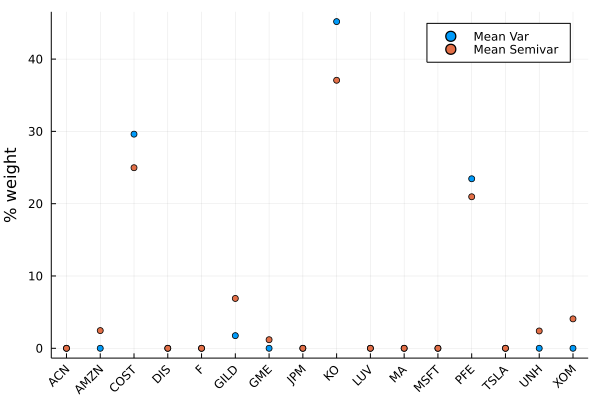

In [49]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45)

We can check the risk, ie semideviation, to see which is lower.

In [50]:
println("Mean variance with semicovariance.")
mu1, sigma1, sr1 = portfolio_performance(emv, verbose=true)
println((mu1, sigma1, sr1))

println("\nMean semivariance optimisation.")
mu2, sigma2, sr2 = portfolio_performance(emsv, verbose=true)
println((mu2, sigma2, sr2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 18.05 %
Annual volatility: 11.28 %
Sharpe Ratio: 1.423
(0.18054757608746236, 0.11280491079746748, 1.4232321532146164)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 19.32 %
Annual semi-deviation: 10.43 %
Sortino Ratio: 1.661
(0.19318382012800067, 0.10426898743227948, 1.660933172871559)


Next we'll show the max utility. Since we've already shown what changing the risk aversion does to the optimisation we'll leave it as the default.

In [51]:
max_utility!(emv)
max_utility!(emsv)

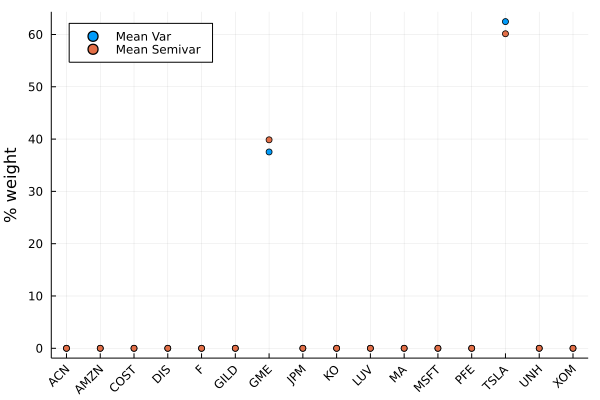

In [52]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

Unfortunately this only gave two assets meaningful weights, this makes the portfolio vulnerable to fluctuations, so lets add a bit of L2 regularisation. L2 reg tends to be more powerful than increasing the risk aversion, but both are viable strategies.

In [53]:
emv = EffMeanVar(tickers, mean_ret, S, extra_obj_terms = (quote L2_reg(model[:w], 0.5) end,))
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns), extra_obj_terms = (quote L2_reg(model[:w], 0.5) end,))

max_utility!(emv)
max_utility!(emsv)

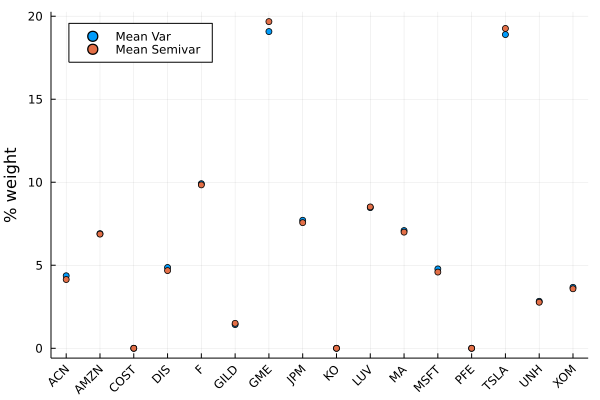

In [54]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [55]:
println("Mean variance with semicovariance.")
mu_u1, sigma_u1, sr_u1 = portfolio_performance(emv, verbose=true)
println((mu_u1, sigma_u1, sr_u1))

println("\nMean semivariance optimisation.")
mu_u2, sigma_u2, sr_u2 = portfolio_performance(emsv, verbose=true)
println((mu_u2, sigma_u2, sr_u2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 34.59 %
Annual volatility: 20.92 %
Sharpe Ratio: 1.558
(0.34592586502722433, 0.20924492123352859, 1.557628558465577)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 34.76 %
Annual semi-deviation: 18.64 %
Sortino Ratio: 1.757
(0.34764596950980764, 0.18643673044593967, 1.7574110462359447)


Lets instead increase the risk aversion to see what it does.

In [56]:
emv = EffMeanVar(tickers, mean_ret, S)
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns))

max_utility!(emv, 8)
max_utility!(emsv, 8)

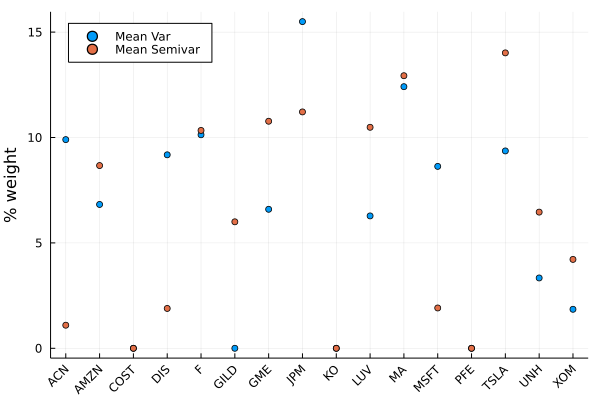

In [57]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [58]:
println("Mean variance with semicovariance.")
mu_u1, sigma_u1, sr_u1 = portfolio_performance(emv, verbose=true)
println((mu_u1, sigma_u1, sr_u1))

println("\nMean semivariance optimisation.")
mu_u2, sigma_u2, sr_u2 = portfolio_performance(emsv, verbose=true)
println((mu_u2, sigma_u2, sr_u2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 30.82 %
Annual volatility: 17.16 %
Sharpe Ratio: 1.679
(0.30821115028447976, 0.17163351881660768, 1.6792241531354755)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 32.29 %
Annual semi-deviation: 16.16 %
Sortino Ratio: 1.874
(0.32292304735133603, 0.16161968397352347, 1.874295505991466)


As you can see, L2 regularisation is quite a bit more powerful than increasing the risk aversion. Both are viable strategies and I would switch it up between strategies when regularly investing. Having multiple varied portfolios across time and markets is a good way of hedging against systemic risk.

Next we'll show the efficient return. We'll use a multiple of the return given by the minimum risk optimisation of the mean semivariance optimiser. 

Change the value to `mu1` and `mu2` and compare to the minimum risk optimisations. What happens if you lower the values to below those given by `min_risk!`?

In [59]:
efficient_return!(emv, 1.5*mu2)# mu1
efficient_return!(emsv, 1.5*mu2)# mu2

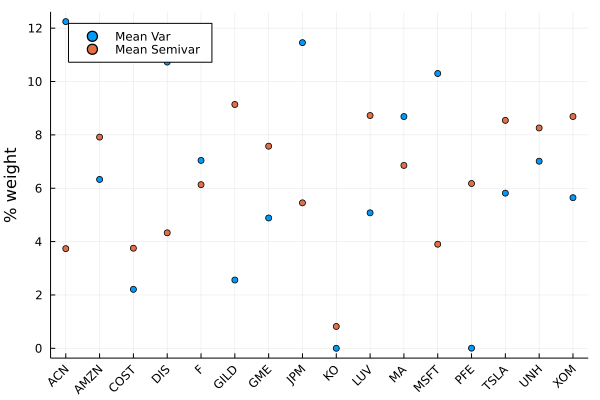

In [60]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [61]:
println("Mean variance with semicovariance.")
mu_er1, sigma_er1, sr_er1 = portfolio_performance(emv, verbose=true)
println((mu_er1, sigma_er1, sr_er1))

println("\nMean semivariance optimisation.")
mu_er2, sigma_er2, sr_er2 = portfolio_performance(emsv, verbose=true)
println((mu_er2, sigma_er2, sr_er2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 28.98 %
Annual volatility: 15.92 %
Sharpe Ratio: 1.695
(0.28977573270527723, 0.15920077133919613, 1.6945629750152906)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 28.98 %
Annual semi-deviation: 13.94 %
Sortino Ratio: 1.935
(0.2897757257196236, 0.13943541037047918, 1.934771985127959)


Next we have the efficient risk optimisation. We'll also use the risk from the minimum risk optimisation as the benchmark. Change it to see what happens. If you go lower than the minimum Ipopt will complain but solve it as best it can. Other optimisers might not do this, so it's always worth checking if the solution is useful.

In [62]:
efficient_risk!(emv, 1.5*sigma2)
efficient_risk!(emsv, 1.5*sigma2)

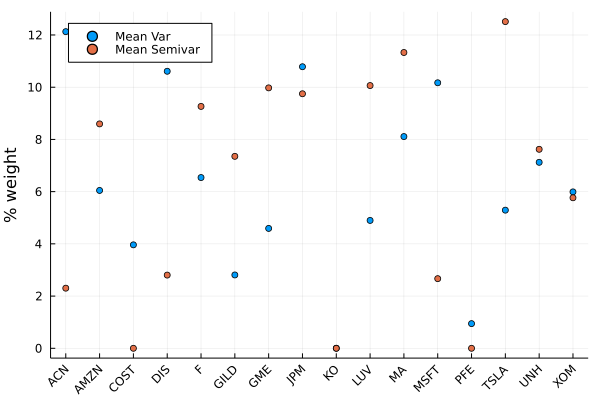

In [63]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [64]:
println("Mean variance with semicovariance.")
mu_es1, sigma_es1, sr_es1 = portfolio_performance(emv, verbose=true)
println((mu_es1, sigma_es1, sr_es1))

println("\nMean semivariance optimisation.")
mu_es2, sigma_es2, sr_es2 = portfolio_performance(emsv, verbose=true)
println((mu_es2, sigma_es2, sr_es2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 28.53 %
Annual volatility: 15.64 %
Sharpe Ratio: 1.696
(0.2852733644551122, 0.1564035126198444, 1.696083163425413)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 31.6 %
Annual semi-deviation: 15.64 %
Sortino Ratio: 1.892
(0.3159704422196782, 0.1564034992210107, 1.892351793238642)


We also have the built-in max sharpe optimisation, which uses the same variable transformation. Remember that for these we have to regenerate the optimiser structures to ensure we don't pollute the variable transformation. Again we have to remember that we're using CAPM returns, which already account for the risk free rate.

In [65]:
emv = EffMeanVar(tickers, mean_ret, S, rf=eps())
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns), rf=eps())

max_sharpe!(emv)
max_sharpe!(emsv)

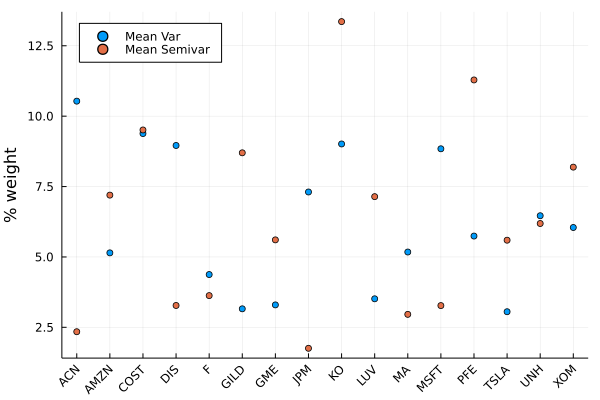

In [66]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [67]:
println("Mean variance with semicovariance.")
mu_sr1, sigma_sr1, sr_sr1 = portfolio_performance(emv, verbose=true)
println((mu_sr1, sigma_sr1, sr_sr1))

println("\nMean semivariance optimisation.")
mu_sr2, sigma_sr2, sr_sr2 = portfolio_performance(emsv, verbose=true)
println((mu_sr2, sigma_sr2, sr_sr2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 25.91 %
Annual volatility: 14.12 %
Sharpe Ratio: 1.835
(0.25914846781333867, 0.14122248964226483, 1.8350368165141093)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 25.75 %
Annual semi-deviation: 12.22 %
Sortino Ratio: 2.108
(0.25754225194173724, 0.12217102041240539, 2.1080469907869075)


We can use the nonlinear optimiser for this just like we did in the previous section. 

We could do the same for the risk measure used in `EffMeanSemivar`, but it takes an age and a half to optimise. So if you need a nonlinear optimisation for mean semivariance, you're better off using `EffMeanVar` and giving it a semicovariance.

In [68]:
nl_emv = EffMeanVar(tickers, mean_ret, S, rf=eps())
# These correspond to obj_params in the demvinition of sharpe_ratio_nl. 
obj_params = [nl_emv.mean_ret, nl_emv.cov_mtx, nl_emv.rf, 0]
# # This should give an answer close to the max_sharpe! optimisation as γ is zero.
custom_nloptimiser!(nl_emv, sharpe_ratio_nl, obj_params)

nl_mu0, nl_sigma0, nl_sr0 = portfolio_performance(nl_emv, verbose=true)

LOCALLY_SOLVED
Expected annual return: 25.91 %
Annual volatility: 14.12 %
Sharpe Ratio: 1.835


(0.2591484923142743, 0.141222502993994, 1.8350368165142583)

We can see that the weights are pretty much the same as for the `max_sharpe!` optimisation of the `EffMeanVar` structure when we provide the semicovariance. Not truly optimal in this space, but if you need extra objective terms on the function it's the only way to ensure they will behave properly. Just remember to add the extra terms to the definition of the nonlinear function.

In [69]:
[tickers nl_emv.weights emv.weights emsv.weights]

16×4 Matrix{Any}:
 "ACN"   0.105334   0.105334   0.0234323
 "AMZN"  0.0514493  0.0514493  0.0719553
 "COST"  0.0938264  0.0938264  0.0950983
 "DIS"   0.0895855  0.0895853  0.0327579
 "F"     0.0437446  0.0437445  0.0362634
 "GILD"  0.0315712  0.0315715  0.0869834
 "GME"   0.0329635  0.0329635  0.0560603
 "JPM"   0.0730692  0.0730691  0.017552
 "KO"    0.0901283  0.0901284  0.133585
 "LUV"   0.0351278  0.035128   0.0714139
 "MA"    0.0517433  0.0517433  0.029602
 "MSFT"  0.0884116  0.0884116  0.0327174
 "PFE"   0.0574124  0.0574124  0.112865
 "TSLA"  0.0305394  0.0305394  0.0559433
 "UNH"   0.0646345  0.0646345  0.0618742
 "XOM"   0.0604591  0.0604591  0.0818958

In theory, the following two cells properly optimise for the mean semivariance non-linearly. However, it takes such a long time that I've commented them out and you should not even try them. For the semivariance optimisation we have a different risk measure, so we have to make a special function for it too. 

Execute at your own peril. I gave up after 10 minutes.

In [70]:
#=
function sortino_ratio(w::T...) where {T}
    mean_ret = obj_params[1]
    rf = obj_params[2]
    freq = obj_params[3]
    num_tickers = obj_params[4]

    weights = w[1:num_tickers]
    n = w[num_tickers+1:end]

    mu = PortfolioOptimiser.port_return(weights, mean_ret) - rf
    sigma = dot(n, n) * freq

    return -mu/sigma
end
=#

In [71]:
#=
nl_emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns), rf=eps())

obj_params = [nl_emsv.mean_ret, nl_emsv.rf, nl_emsv.freq, length(tickers)]
custom_nloptimiser!(nl_emsv, sortino_ratio, obj_params, [(nl_emsv.model[:n], 1 / length(nl_emsv.model[:n]))])

portfolio_performance(nl_emsv, verbose=true)
[tickers nl_emsv.weights]
=#

The reason why the `EffMeanSemivar` struct is truly optimum in mean-semivariance space is because it takes into account all historical entries, whereas the covariance is a summary of the overall behaviour. The `EffMeanSemivar` generates a constraint on the portfolio returns (adjusted to the target for discerning upside and downside returns and number of observations), for each observation.

In [72]:
length(emsv.model[:semi_var])

3017

## Conditional Value at Risk

Conditional value at risk is the average of some percentage of the worst case loss scenarios, see [here](https://www.ise.ufl.edu/uryasev/files/2011/11/VaR_vs_CVaR_INFORMS.pdf), figure 1 does a good job of explaining the difference between VaR and CVaR. `PortfolioOptimiser.jl` defaults to a confidence level of 95 %, this can be changed with the `beta` keyword argument.

We'll use ECAPM returns with a shrunken covariance, there's no reason why you couldn't use a semicovariance.

Note that CVaR can be quite sensitive to weight fluctuations, small changes in the weights can affect the calculated portfolio performance. This becomes evident if you set the risk aversion to 1 in `max_utility!`, and when using `max_sharpe!`.

In [73]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    # cspan = num_rows,
    # rspan = num_rows,
    cov_type = CustomCov(),
    custom_cov_estimator = method,
);

We can show the effect of the confidence level.

In [74]:
# Average worst 1 %.
cv1 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.99)
# Average worst 5 %.
cv2 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.95)
# Average worst 10 %.
cv3 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.90)
# Average worst 15 %.
cv4 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.85);

In [75]:
min_risk!(cv1)
min_risk!(cv2)
min_risk!(cv3)
min_risk!(cv4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 3.53719e-7  1.42034e-6  2.03008e-6  5.96122e-6
 7.20854e-7  7.88948e-6  0.00822658  0.0198773
 0.228416    0.262457    0.248501    0.232388
 5.67887e-7  1.41433e-6  2.9047e-6   0.000141076
 2.52516e-7  4.61817e-7  7.74289e-7  1.05586e-6
 0.0959772   0.0878169   0.0511578   0.0419383
 0.0426017   0.00624243  0.00872952  0.0106333
 2.34922e-7  4.26124e-7  8.53501e-7  1.31056e-6
 0.332122    0.384286    0.399533    0.391876
 2.77207e-7  7.27477e-7  5.45657e-6  0.0102329
 2.49449e-7  5.63681e-7  9.3569e-7   1.49413e-6
 6.0511e-7   1.74352e-6  3.93589e-6  5.87703e-6
 0.280875    0.222213    0.200698    0.179557
 2.54433e-7  7.87073e-7  1.03243e-6  1.06328e-6
 8.20504e-7  0.0216334   0.0502575   0.0634272
 0.0200041   0.0153365   0.0328798   0.0499121

In [76]:
println("CVaR at worst 1 % of cases")
mu1, cvar1 = portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
mu2, cvar2 = portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
mu3, cvar3 = portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
mu4, cvar4 = portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 17.57 %
Conditional Value at Risk: 3.83 %
Ratio: 4.589

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 16.01 %
Conditional Value at Risk: 2.17 %
Ratio: 7.388

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 16.3 %
Conditional Value at Risk: 1.64 %
Ratio: 9.932

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 16.74 %
Conditional Value at Risk: 1.35 %
Ratio: 12.379


As you can see, as you drop the confidence level, the value of CVaR decreases. This follows from the fact that the worst 1 % of all losses will be worse by definition than the worst 10 % of all losses. By increasing the value of `beta`, we fixate on minimising the worst losses.

We can see how the portfolios look in comparison to one another.

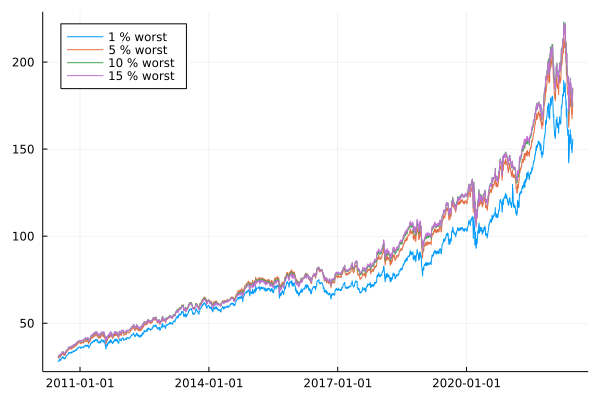

In [77]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

As you can see, there are deminishing returns to increasing the value of `beta`.

We also have an optimisation to maximise utility. However, you sometimes have to set the risk aversion to be quite high for it to have an impact. Alternatively, use the L2 regularisation.

In [78]:
max_utility!(cv1, 10)
max_utility!(cv2, 10)
max_utility!(cv3, 10)
max_utility!(cv4, 10)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 1.53874e-7  4.25782e-8  3.55523e-8  1.34805e-8
 0.146033    6.10733e-8  4.5075e-8   1.8062e-8
 1.0593e-7   5.27754e-9  1.25248e-8  5.14661e-9
 4.5228e-7   3.21595e-8  3.1867e-8   1.28453e-8
 0.110764    0.0421488   9.75432e-8  2.46805e-8
 0.114964    1.97201e-8  1.88905e-8  7.56432e-9
 0.130399    0.328915    0.697491    0.828389
 0.22628     0.138217    8.54156e-8  2.08233e-8
 4.53807e-8  3.96884e-9  1.07e-8     4.40883e-9
 0.0113472   6.83878e-8  4.97321e-8  1.80408e-8
 0.141307    0.291154    9.18792e-8  2.47893e-8
 1.41189e-7  6.98484e-8  4.01684e-8  1.58989e-8
 9.87479e-8  9.40716e-9  1.36135e-8  5.48668e-9
 0.118904    0.199566    0.302508    0.171611
 5.108e-8    3.1898e-8   3.12861e-8  1.20485e-8
 1.90089e-7  1.97784e-8  2.72117e-8  1.06453e-8

In [79]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 31.59 %
Conditional Value at Risk: 5.49 %
Ratio: 5.753

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 39.96 %
Conditional Value at Risk: 4.75 %
Ratio: 8.407

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 52.88 %
Conditional Value at Risk: 5.67 %
Ratio: 9.334

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 55.37 %
Conditional Value at Risk: 5.06 %
Ratio: 10.952


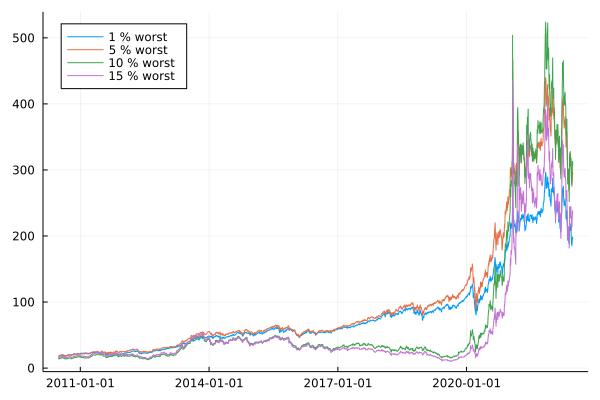

In [80]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

You can see how maximising utility may not be the best choice in this case, as it is a lot more volatile, even while being quite risk averse.

Similarly to the other efficient frontier optimisations, we also have `efficient_return!`, `efficient_risk!` and `max_sharpe!`, the same rules apply for them all.

We'll calculate the efficient return for twice the expected return of the minimum CVaR of each portfolio.

In [81]:
efficient_return!(cv1, 2 * mu1)
efficient_return!(cv2, 2 * mu2)
efficient_return!(cv3, 2 * mu3)
efficient_return!(cv4, 2 * mu4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 3.29058e-7  1.48978e-5   7.76142e-6  1.39405e-5
 0.0354637   1.18069e-6   2.54238e-5  4.08533e-5
 1.311e-7    1.89675e-6   9.17656e-6  2.70776e-6
 5.22972e-7  0.000236507  0.0298039   0.029263
 0.159375    0.0414158    0.0537871   0.0490254
 3.11104e-7  0.095662     0.0256099   0.0221344
 0.16828     0.165949     0.193355    0.210705
 0.213034    0.15595      0.0627834   0.116945
 8.98356e-8  3.76151e-6   2.45819e-5  3.53545e-6
 6.21637e-7  1.74914e-5   0.0613044   0.0256065
 0.218572    0.244961     0.177053    0.163391
 2.61988e-7  0.0493878    0.0538695   0.105766
 1.13582e-7  0.043812     0.0180969   5.45496e-6
 0.205273    0.128556     0.113291    0.111701
 1.22821e-7  0.0490216    0.177922    0.144346
 2.03309e-7  0.0250087    0.0330564   0.0210499

In [82]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 35.15 %
Conditional Value at Risk: 6.41 %
Ratio: 5.487

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 32.01 %
Conditional Value at Risk: 3.51 %
Ratio: 9.109

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 32.6 %
Conditional Value at Risk: 2.72 %
Ratio: 11.982

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 33.48 %
Conditional Value at Risk: 2.33 %
Ratio: 14.374


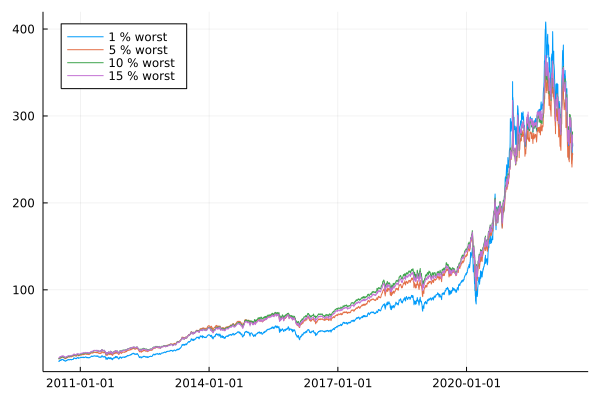

In [83]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can do the same for the efficient risk.

In [84]:
efficient_risk!(cv1, 2 * cvar1)
efficient_risk!(cv2, 2 * cvar2)
efficient_risk!(cv3, 2 * cvar3)
efficient_risk!(cv4, 2 * cvar4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 9.02568e-8  2.4326e-7   2.38413e-7  6.59463e-7
 6.97135e-7  3.46722e-7  4.6218e-7   1.4671e-6
 3.10213e-8  5.36917e-8  8.29144e-8  7.88539e-8
 1.50308e-7  1.73714e-7  4.58881e-7  8.29013e-5
 0.073089    0.0728402   0.0416145   0.0203778
 8.27626e-8  1.60351e-7  3.65597e-7  1.8435e-7
 0.237786    0.266957    0.286487    0.294295
 0.0333852   0.179382    0.137322    0.137069
 1.86575e-8  4.91572e-8  6.95518e-8  7.89653e-8
 2.77322e-7  4.61194e-7  5.39047e-7  0.0149839
 0.321263    0.284024    0.257365    0.216366
 7.47864e-8  5.88323e-6  0.0197677   0.0865418
 2.45287e-8  8.53845e-8  9.40285e-8  1.12138e-7
 0.334475    0.177382    0.169653    0.151184
 3.38068e-8  0.019408    0.0877877   0.0790959
 5.56681e-8  1.34651e-7  2.59235e-7  1.40943e-6

In [85]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 38.82 %
Conditional Value at Risk: 7.66 %
Ratio: 5.069

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 37.67 %
Conditional Value at Risk: 4.33 %
Ratio: 8.693

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 37.63 %
Conditional Value at Risk: 3.28 %
Ratio: 11.464

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 37.44 %
Conditional Value at Risk: 2.7 %
Ratio: 13.842


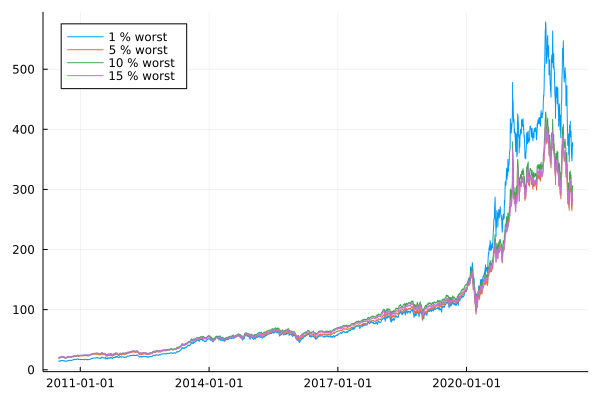

In [86]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can also optimise for the maximum sharpe ratio. And remember that we have to create fresh instances due to the variable transformation. We'll have a sharpe ratio of zero because we use ECAPM mean returns which already account for it.

In [87]:
# Average worst 1 %.
cv1 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.99, rf=0)
# Average worst 5 %.
cv2 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.95, rf=0)
# Average worst 10 %.
cv3 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.90, rf=0)
# Average worst 15 %.
cv4 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.85, rf=0);

In [88]:
max_sharpe!(cv1)
max_sharpe!(cv2)
max_sharpe!(cv3)
max_sharpe!(cv4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 3.94478e-7  0.00460298  4.06859e-6  3.01193e-5
 0.198365    5.01988e-7  0.0165641   0.0131455
 9.93909e-7  0.0451002   0.073448    0.0858355
 5.64639e-7  0.0582879   0.0438128   0.0220174
 0.0762445   0.0452855   0.014624    0.0125062
 0.176103    0.0936937   0.0448806   0.0286773
 0.114353    0.116871    0.115728    0.106455
 0.200077    0.0194788   0.0504334   0.051003
 1.30663e-7  0.11044     0.130624    0.16304
 0.0276804   0.0458537   0.049669    0.0358335
 0.0923276   0.0875152   0.0898854   0.116929
 3.38872e-7  0.0440665   0.0248378   0.0824815
 4.54573e-7  0.125318    0.0938506   0.0643082
 0.0980558   0.0846697   0.0646918   0.0508788
 1.20989e-7  0.0799705   0.148374    0.110162
 0.0167901   0.0388454   0.0385721   0.056696

In [89]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 30.03 %
Conditional Value at Risk: 17.33 %
Ratio: 1.732

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 26.66 %
Conditional Value at Risk: 10.81 %
Ratio: 2.466

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 26.17 %
Conditional Value at Risk: 8.17 %
Ratio: 3.205

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 25.65 %
Conditional Value at Risk: 6.7 %
Ratio: 3.826


Note how these values are worse than for the other optimisations. This is due to the sensitivity of CVaR to small fluctuations in the asset weights.

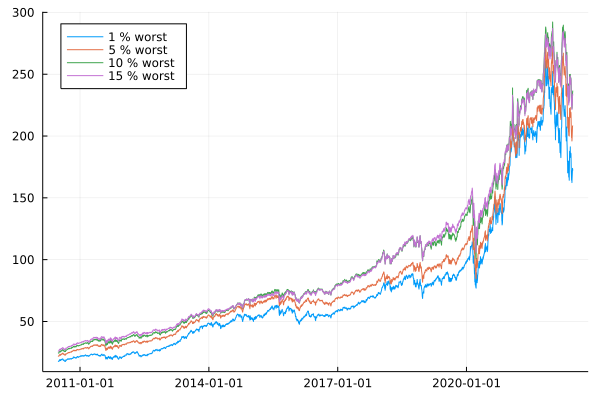

In [90]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can also use the nonlinear optimiser, but it takes quite long and tends to fail/hang. I would avoid it or pass optimiser attributes that would limit execution times with the `optimiser_attributes` keyword argument. Besides, for CVaR, the best optimisations are `min_risk!`, `efficient_return!` and `efficient_risk!`.

In [107]:
function cvar_ratio(w...)
    mean_ret = obj_params[1]
    beta = obj_params[2]
    rf = obj_params[3]
    num_tickers = obj_params[4]
    samples = obj_params[5]

    weights = [i for i in w[1:num_tickers]]
    alpha = w[num_tickers+1]
    u = [i for i in w[num_tickers+2:end]]

    mu = PortfolioOptimiser.port_return(weights, mean_ret) - rf
    CVaR = PortfolioOptimiser.cvar(alpha, u, samples, beta)

    return -mu / CVaR
end

cvar_ratio (generic function with 1 method)

In [130]:
cv = EffCVaR(tickers, mean_ret, Matrix(returns), rf=0);

In [131]:
obj_params = [cv.mean_ret, cv.beta, cv.rf, length(cv.tickers), size(cv.returns, 1)]
extra_vars = [(cv.model[:alpha], 0.1), (cv.model[:u], fill(1 / length(cv.model[:u]), length(cv.model[:u])))]
custom_nloptimiser!(cv, cvar_ratio, obj_params, extra_vars, optimiser_attributes = ("max_iter" => 30))

┌ Warning: The optimiser could not solve the problem satisfactorily: ITERATION_LIMIT. The solution may be useful regardless.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:418


## Conditional Drawdown at Risk